In [1]:
!pwd
# %cd content
# !rm -r MedGenie

!git clone https://github.com/kacpermarzol/MedGenie.git


/content
fatal: destination path 'MedGenie' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

video_folder_path = '/content/drive/My Drive/MedGS/prostate_paper_img/original'
mask_folder_path = '/content/drive/My Drive/MedGS/prostate_paper_labels/original'


Mounted at /content/drive


In [3]:
import os
from PIL import Image
import numpy as np

def load_video_frames_for_3d(folder_path, grayscale=False):
    frame_files = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    frames = []
    for f in frame_files:
        img = Image.open(f)
        if grayscale:
            img = img.convert("L")
        else:
            img = img.convert("RGB")
        frames.append(np.array(img)/255)

    frames = np.stack(frames, axis=0)
    if grayscale and frames.ndim == 3:
        frames = frames[..., None]

    return frames


video_frames = load_video_frames_for_3d(video_folder_path, grayscale=True)
num_frames, height, width, _ = video_frames.shape

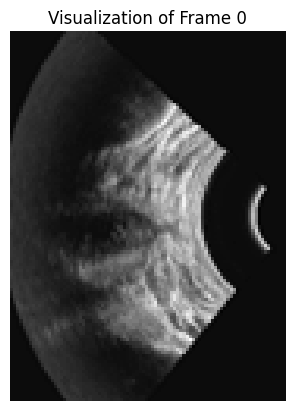

In [4]:
import matplotlib.pyplot as plt

frame_index = 0
if frame_index < len(video_frames):
    frame_to_display = video_frames[frame_index]
    if frame_to_display.shape[-1] == 1:
        frame_to_display = frame_to_display.squeeze(-1)
    plt.imshow(frame_to_display, cmap='gray')
    plt.title(f"Visualization of Frame {frame_index}")
    plt.axis('off')
    plt.show()
else:
    print(f"Frame index {frame_index} is out of bounds. The video has {len(video_frames)} frames.")

In [5]:
import torch
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, video_folder_path, grayscale=True):
        super().__init__()
        self.video_frames = load_video_frames_for_3d(video_folder_path, grayscale=grayscale)
        self.num_frames, self.height, self.width, self.channels = self.video_frames.shape
        self.coords_single_frame = self.get_mgrid_original_size(self.width, self.height)
        self.time_coords = torch.linspace(0, 1, self.num_frames)
        self.pixels = torch.tensor(self.video_frames, dtype=torch.float32).view(-1, self.channels)

    def get_mgrid_original_size(self, sidelength_x, sidelength_y):
        tensors = (torch.linspace(0, 1, steps=sidelength_x), torch.linspace(0, 1, steps=sidelength_y))
        mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
        mgrid = mgrid.reshape(-1, 2)
        return mgrid

    def __len__(self):
        return self.num_frames * self.height * self.width

    def __getitem__(self, idx):
        frame_idx = idx // (self.height * self.width)
        pixel_idx_in_frame = idx % (self.height * self.width)
        coord_xy = self.coords_single_frame[pixel_idx_in_frame]
        time_coord = self.time_coords[frame_idx].unsqueeze(-1)
        input_coords = torch.cat((coord_xy, time_coord), dim=-1)
        ground_truth_pixel = self.pixels[idx]
        return input_coords, ground_truth_pixel

In [6]:
video_dataset = VideoDataset(video_folder_path, grayscale=True)
first_input, first_gt = video_dataset[2]
print("Input coordinates (x, y, t):", first_input)
print("Ground truth pixel value:", first_gt)
print("Total number of samples:", len(video_dataset))

Input coordinates (x, y, t): tensor([0.0000, 0.0171, 0.0000])
Ground truth pixel value: tensor([0.0471])
Total number of samples: 841104


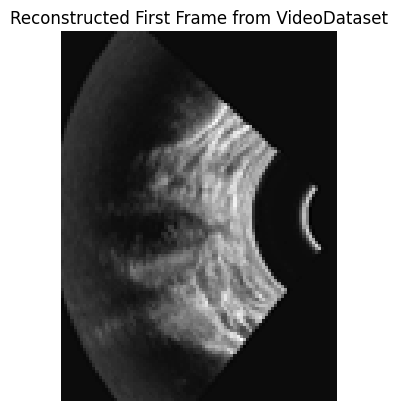

In [7]:
if 'video_dataset' in locals() and 'video_frames' in locals() and len(video_frames) > 0:
    height = video_dataset.height
    width = video_dataset.width
    channels = video_dataset.channels
    first_frame_pixels_flat = video_dataset.pixels[:height * width]
    if channels == 1:
        reconstructed_frame = first_frame_pixels_flat.view(height, width).numpy()
        cmap = 'gray'
    else:
        reconstructed_frame = first_frame_pixels_flat.view(height, width, channels).numpy()
        cmap = None
    plt.imshow(reconstructed_frame, cmap=cmap)
    plt.title("Reconstructed First Frame from VideoDataset")
    plt.axis('off')
    plt.show()
else:
    print("video_dataset or video_frames is not loaded. Please run the previous cells to create the dataset and load video frames.")

In [2]:
!pip install nerfstudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.8/580.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.6 MB/s eta 0:00:00
   ━━━

In [9]:
! pwd
%cd MedGenie

/content
/content/MedGenie


In [93]:
from typing import Optional, Callable, Union, Dict, List
import numpy as np
import torch
from torch import Tensor, nn

class SpatialDistortion:
    def __call__(self, x: Tensor) -> Tensor:
        return x


class HashEncoding(nn.Module):
    def __init__(self, in_dim: int = 3, num_levels: int = 4, features_per_level: int = 8):
        super().__init__()
        self.in_dim = in_dim
        self.num_levels = num_levels
        self.features_per_level = features_per_level
        self.freq_bands = 2.0 ** torch.linspace(0, num_levels - 1, num_levels)

    def forward(self, x: Tensor) -> Tensor:
        outs = [x]
        for f in self.freq_bands:
            outs.append(torch.sin(x * f * np.pi))
            outs.append(torch.cos(x * f * np.pi))
        return torch.cat(outs, dim=-1)


class SplashEncoding(nn.Module):
    def __init__(
        self,
        n_gausses: int = 10000,
        n_features_per_gauss: int = 32,
        knn_algorithm: Optional[object] = None,
        means: Optional[Tensor] = None,
        densify: bool = True,
        prune: bool = True,
        unfreeze_means: bool = True,
        spatial_distortion: Optional[SpatialDistortion] = None,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        empty_as_hash: bool = False,
    ):
        super().__init__()
        assert knn_algorithm is not None, "KNN algorithm must be provided"

        self.device = device
        self.n_features_per_gauss = n_features_per_gauss
        self.densify_gausses = densify
        self.prune_gausses = prune
        self.unfreeze_gausses = unfreeze_means
        self.empty_as_hash = empty_as_hash
        self.spatial_distortion = spatial_distortion or SpatialDistortion()

        if means is not None:
            if isinstance(means, np.ndarray):
                means = torch.tensor(means, dtype=torch.float32, device=self.device)
            else:
                means = means.to(self.device)
        else:
            means = self.init_mean(n_gausses)

        self.total_gaus = means.shape[0]
        means = nn.Parameter(means, requires_grad=False)

        self.hash_encoding = HashEncoding(in_dim=3)
        self.means_hash = HashEncoding(in_dim=3)

        self.register_buffer("feats", self.means_hash(means))
        log_covs = nn.Parameter(torch.log(torch.ones(self.total_gaus, 3, device=self.device) * 0.0001))
        self.confidence = torch.ones(self.total_gaus, device=self.device)

        self.gauss_params = nn.ParameterDict({
            "means": means,
            "log_covs": log_covs
        })

        self.knn = knn_algorithm

    def init_mean(self, N: int) -> Tensor:
        print(f"Initializing {N} Gaussian centers...")
        pts = np.random.randn(N, 3)
        r = np.sqrt(np.random.rand(N, 1))
        pts = pts / np.linalg.norm(pts, axis=1)[:, None] * r
        pts = pts * 0.5 + 0.5
        return torch.tensor(pts, device=self.device)

    @property
    def means(self) -> Tensor:
        return self.gauss_params["means"]

    @property
    def log_covs(self) -> Tensor:
        return self.gauss_params["log_covs"]

    def get_out_dim(self) -> int:
        return self.n_features_per_gauss


    def interpolate(self, coords: Tensor, nearest_gauss_indices: Tensor) -> Tensor:
        if self.training:
            self.feats = self.means_hash(self.means)

        nearest_features = self.feats[nearest_gauss_indices]
        nearest_covs = torch.exp(self.log_covs[nearest_gauss_indices])

        diff = coords[:, None, :] - self.means[nearest_gauss_indices]
        mdist = (diff ** 2 / nearest_covs).sum(-1)

        gau_weights = torch.exp(-0.5 * mdist)
        weighted_features = nearest_features * gau_weights.unsqueeze(-1)

        return torch.sum(weighted_features, dim=1)


    def forward(self, coords: Tensor) -> Tensor:
        coords = self.spatial_distortion(coords)

        with torch.no_grad():
            # sigma_max, _ = torch.sqrt(torch.exp(self.log_covs)).max(dim=-1)
            # pad_means = torch.cat([self.means, sigma_max.unsqueeze(-1)], dim=1)
            self.knn.fit(coords)
            nearest_indices, _ = self.knn.get_nearest_neighbours(coords)
            nearest_indices = torch.clamp(nearest_indices, 0, self.means.shape[0] - 1)

        splash_feats = self.interpolate(coords, nearest_indices)
        if self.empty_as_hash:
            hash_feats = self.hash_encoding(coords)
            mask = (nearest_indices > 0).all(dim=1)
            feats = torch.where(mask.unsqueeze(-1), splash_feats, hash_feats)
        else:
            feats = splash_feats

        if self.training:
            self.confidence -= 0.001
            self.confidence[nearest_indices] += 0.01
            self.confidence.clamp_(0.0, 1.0)
        return feats.to(coords.dtype)


In [102]:
from typing import Literal, Optional, Set, Tuple

import torch
from torch import Tensor, nn

class MLP(nn.Module):
    def __init__(
        self,
        in_dim: int,
        num_layers: int,
        layer_width: int,
        out_dim: Optional[int] = None,
        activation: Optional[nn.Module] = nn.ReLU(),
        out_activation: Optional[nn.Module] = None,
    ) -> None:
        super().__init__()
        assert in_dim > 0
        self.in_dim = in_dim
        self.num_layers = num_layers
        self.layer_width = layer_width
        self.out_dim = out_dim if out_dim is not None else layer_width
        self.activation = activation
        self.out_activation = out_activation

        self.build_nn_modules()

    def build_nn_modules(self) -> None:
        layers = []
        for i in range(self.num_layers):
            input_dim = self.in_dim if i == 0 else self.layer_width
            output_dim = self.out_dim if i == self.num_layers - 1 else self.layer_width
            layers.append(nn.Linear(input_dim, output_dim))
        self.layers = nn.ModuleList(layers)

    def forward(self, x: Tensor) -> Tensor:
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1 and self.activation is not None:
                x = self.activation(x)
        if self.out_activation is not None:
            x = self.out_activation(x)
        return x

class MLPWithHashEncoding(nn.Module):
    def __init__(
        self,
        knn_algorithm: Optional[object] = None,
        n_features_per_gauss: int = 27,
        num_layers: int = 2,
        layer_width: int = 64,
        out_dim: Optional[int] = None,
        skip_connections: Optional[Tuple[int]] = None,
        activation: Optional[nn.Module] = nn.ReLU(),
        out_activation: Optional[nn.Module] = None,
        seed_points: Optional[Tensor] = None,
        densify: bool = True,
        prune: bool = True,
        unfreeze_means: bool = True,
        spatial_distortion: Optional[SpatialDistortion] = None,
    ) -> None:
        super().__init__()

        self.in_dim = 3
        self.encoder = SplashEncoding(
            n_features_per_gauss=n_features_per_gauss,
            n_gausses=40000,
            knn_algorithm=knn_algorithm,
            means=seed_points,
            densify=densify,
            prune=prune,
            unfreeze_means=unfreeze_means,
            spatial_distortion=spatial_distortion,
        )

        self.mlp = MLP(
            in_dim=self.encoder.get_out_dim(),
            num_layers=num_layers,
            layer_width=layer_width,
            out_dim=out_dim,
            activation=activation,
            out_activation=out_activation,
        )

    def forward(self, x: Tensor) -> Tensor:
        encoded = self.encoder(x)
        return self.mlp(encoded)

In [103]:
!ls
# %cd MedGenie/

blender  genie	 LICENSE	 pyproject.toml
docker	 images  medgenie.ipynb  README.md


In [104]:
# !git pull

In [130]:
from torch.utils.data import DataLoader
from genie.knn.knn_algorithms import TorchKNNConfig, TorchKNN

knn_config = TorchKNNConfig()
knn = TorchKNN(knn_config)


mlp = MLPWithHashEncoding(knn_algorithm = knn,
                          out_dim = 1
                          ).cuda()



learning_rate = 0.00001
num_epochs = 100
batch_size = 1024

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

dataloader = DataLoader(video_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.to(device)

print("Starting training...")
for epoch in range(num_epochs):
    mlp.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(inputs)
        if i % 100 == 0:
          print(inputs[0], labels[0].item(), outputs[0].item())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")

Initializing 40000 Gaussian centers...
Starting training...
tensor([0.4483, 0.4017, 0.8625], device='cuda:0') 0.04313725605607033 -0.024423614144325256
tensor([0.1379, 0.8632, 0.9625], device='cuda:0') 0.18431372940540314 -0.019144438207149506
tensor([1.0000, 0.1795, 0.1750], device='cuda:0') 0.03921568766236305 -0.013901129364967346
tensor([0.1724, 0.6410, 0.9875], device='cuda:0') 0.05098039284348488 -0.008615832775831223
tensor([0.7241, 0.3162, 0.5000], device='cuda:0') 0.0470588244497776 -0.003384772688150406
tensor([1.0000, 0.6068, 0.0875], device='cuda:0') 0.11372549086809158 0.0018365532159805298
tensor([0.0575, 0.6068, 0.2375], device='cuda:0') 0.04313725605607033 0.006987482309341431
tensor([0.7471, 0.9316, 0.8250], device='cuda:0') 0.11764705926179886 0.012084633111953735
tensor([0.8046, 0.0598, 0.7375], device='cuda:0') 0.05098039284348488 0.017174940556287766
Epoch [1/100], Loss: 0.1140
tensor([0.5402, 0.9573, 0.0250], device='cuda:0') 0.10588235408067703 0.0182891413569450

In [1]:
mlp.eval()
frame_index_to_reconstruct =  23
if frame_index_to_reconstruct < len(video_frames):
    height = video_dataset.height
    width = video_dataset.width
    time_coord_for_frame = video_dataset.time_coords[frame_index_to_reconstruct].unsqueeze(-1)
    coords_single_frame = video_dataset.coords_single_frame
    input_coords_for_frame = torch.cat((coords_single_frame, time_coord_for_frame.expand(coords_single_frame.shape[0], -1)), dim=-1)


    input_coords_for_frame = input_coords_for_frame.to(device)
    with torch.no_grad():
        reconstructed_pixels_flat = mlp(input_coords_for_frame)

    if video_dataset.channels == 1:
        reconstructed_frame = reconstructed_pixels_flat.view(height, width).cpu().numpy()
        cmap = 'gray'
    else:
        reconstructed_frame = reconstructed_pixels_flat.view(height, width, video_dataset.channels).cpu().numpy()
        cmap = None


    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    original_frame = video_frames[frame_index_to_reconstruct].squeeze(-1) if video_dataset.channels == 1 else video_frames[frame_index_to_reconstruct]
    plt.imshow(original_frame, cmap=cmap)
    plt.title(f"Original Frame {frame_index_to_reconstruct}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_frame, cmap=cmap)
    plt.title(f"Reconstructed Frame {frame_index_to_reconstruct}")
    plt.axis('off')

    plt.show()

else:
    print(f"Frame index {frame_index_to_reconstruct} is out of bounds. The video has {len(video_frames)} frames.")

NameError: name 'mlp' is not defined